# Olympics Analysis 1896 to 2016, A deep Dive

### By Obira Daniel,

### Data from SportsStats
#### Learn SQL Basics for Data Science Specialization Capstone, Cousera, UC Davis

# 1.0 Data Description, Importing and Checking the Data

 ***I created a parquet file from the csv file, reduced the file from ~40MB to ~5.6MB, it downloads and loads faster using pyarrow***<br>
 
 *Data is read from the web and loaded in to a sqlite database then all analysis stems from SQL queries*<br>
 ***sqlite3***, ***ipython-sql*** *and* ***pyarrow*** *are required for SQL and parquet interfacing accordingly*

## 1.1 Data Description
***
The file athlete_events.csv or olympics.parquet, contains 271,116 rows and 15 columns.<br>
Each row/record corresponds to an individual athlete competing in an individual Olympic event (athlete-events).<br>
The columns are the following:
***
*ID - Unique ID for each individual athlete e.g 55881 for Michael Jordan, 13029 for Usain Bolt;<br>*
*Name - Athlete's Full name;<br>*
Sex - M or F;<br>
Age - 64 bit Float of Age in Years;<br>
Height - 64 bit Float of height In centimeters;<br>
Weight - 64 bit Float of Mass In kilograms;<br>
Team - Team name;<br>
NOC - National Olympic Committee 3-letter code;<br>
Games - Year and season;<br>
Year - Integer of Year of Event;<br>
Season - Summer or Winter;<br>
City - Host city;<br>
Sport - Sport;<br>
Event - Event;<br>
Medal - Gold, Silver, Bronze, or NA.<br>

### 1.2 Data Import, Quick Exploration and Quality Checks

#### 1.21 Data Import/Loading

In [67]:
import os, datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import pyarrow
import sqlite3

startTime = datetime.datetime.now()
#file='athlete_events.csv'
#Printing Styling
class style():
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    RESET = '\033[0m'
    BOLD = '\033[1m'

#csvfile='https://raw.githubusercontent.com/obiradaniel/od_olympics/main/athlete_events.csv'

parquetfile='https://raw.githubusercontent.com/obiradaniel/od_olympics/main/olympics.parquet'

worldcountries = 'https://raw.githubusercontent.com/obiradaniel/od_olympics/main/world_countries.csv'

nocfile = "https://raw.githubusercontent.com/obiradaniel/od_olympics/main/noc_regions.csv"

olympics = pd.read_parquet(parquetfile, engine="pyarrow")
noc = pd.read_csv(nocfile)
countries = pd.read_csv(worldcountries)

olympics.head()

ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball  None  
1      Judo Men's Extra-Lightweight  None  
2           Football Men's Football  None  
3       Tug-Of-War Men's Tug-Of-War  Gold  
4  Speed Skating Women's 500 metres  None

In [68]:
noc.describe(include='all')

NOC  Country                 notes
count   232      232                    21
unique  232      209                    21
top     AFG  Germany  Netherlands Antilles
freq      1        4                     1

*They are 230 Unique NOCS and 206 uniqure reions or countries,<br>
this data will be joined to the main olympic dataset after some basic cleaning*

***Olympic Data Schema***

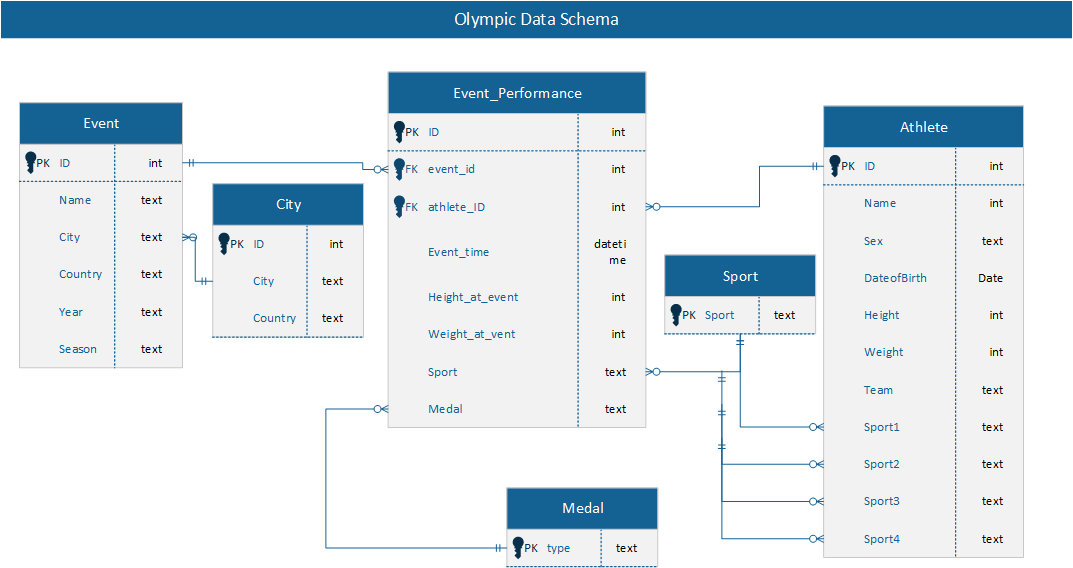

## 1.3 Checking the data for consistency and errors

In [69]:
records = olympics.shape[0]
columns = olympics.shape[1]

print("\nThe data has", records, "records and ", columns, "columns.\n")
print("Data Information Summary")
print(olympics.info())


The data has 271116 records and  15 columns.

Data Information Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB
None


In [70]:
print("Null Value Summary")
olympics.isnull().sum(axis = 0)

Null Value Summary


ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [71]:
print("Range of years is from", min(olympics.Year), "to ", max(olympics.Year))

Range of years is from 1896 to  2016


### 1.3.1 Data Description before Cleaning

In [72]:
print("Data Description for all Variables before cleaning")
olympics.describe(include='all')

Data Description for all Variables before cleaning


ID                  Name     Sex            Age  \
count   271116.000000                271116  271116  261642.000000   
unique            NaN                134732       2            NaN   
top               NaN  Robert Tait McKenzie       M            NaN   
freq              NaN                    58  196594            NaN   
mean     68248.954396                   NaN     NaN      25.556898   
std      39022.286345                   NaN     NaN       6.393561   
min          1.000000                   NaN     NaN      10.000000   
25%      34643.000000                   NaN     NaN      21.000000   
50%      68205.000000                   NaN     NaN      24.000000   
75%     102097.250000                   NaN     NaN      28.000000   
max     135571.000000                   NaN     NaN      97.000000   

               Height         Weight           Team     NOC        Games  \
count   210945.000000  208241.000000         271116  271116       271116   
unique            NaN            NaN           1184     230           51   
top               NaN            NaN  United States     USA  2000 Summer   
freq              NaN            NaN          17847   18853        13821   
mean       175.338970      70.702393            NaN     NaN          NaN   
std         10.518462      14.348020            NaN     NaN          NaN   
min        127.000000      25.000000            NaN     NaN          NaN   
25%        168.000000      60.000000            NaN     NaN          NaN   
50%        175.000000      70.000000            NaN     NaN          NaN   
75%        183.000000      79.000000            NaN     NaN          NaN   
max        226.000000     214.000000            NaN     NaN          NaN   

                 Year  Season    City      Sport                    Event  \
count   271116.000000  271116  271116     271116                   271116   
unique            NaN       2      42         66                      765   
top               NaN  Summer  London  Athletics  Football Men's Football   
freq              NaN  222552   22426      38624                     5733   
mean      1978.378480     NaN     NaN        NaN                      NaN   
std         29.877632     NaN     NaN        NaN                      NaN   
min       1896.000000     NaN     NaN        NaN                      NaN   
25%       1960.000000     NaN     NaN        NaN                      NaN   
50%       1988.000000     NaN     NaN        NaN                      NaN   
75%       2002.000000     NaN     NaN        NaN                      NaN   
max       2016.000000     NaN     NaN        NaN                      NaN   

        Medal  
count   39783  
unique      3  
top      Gold  
freq    13372  
mean      NaN  
std       NaN  
min       NaN  
25%       NaN  
50%       NaN  
75%       NaN  
max       NaN

***Observations***<br>
1. Numeric Variables
    1. ID seems to show 135,571 unique athletes have ever attended the Olympics
    2. Age has extreme value of 97 years and so does weight with 214 Kg, this will have to be explored
    3. The rest seem fine
2. Text Variables
    1. Names shows 134732 unique values
    2. City, 42 Different Cities, a map will show them well
    3. Rest seem fine

***Checking for Usain Bolt in that data***

In [73]:
olympics.loc[olympics['Name'].str.contains('usain', case=False)].head()

ID                          Name Sex   Age  Height  Weight     Team  \
3344    1883  Mamdooh Husain Isa Al-Doseri   M  20.0     NaN     NaN  Bahrain   
3595    2061             Husain Al-Mutairi   M  18.0   170.0    52.0   Kuwait   
24876  13029            Usain St. Leo Bolt   M  17.0   196.0    95.0  Jamaica   
24877  13029            Usain St. Leo Bolt   M  21.0   196.0    95.0  Jamaica   
24878  13029            Usain St. Leo Bolt   M  21.0   196.0    95.0  Jamaica   

       NOC        Games  Year  Season       City      Sport  \
3344   BRN  1992 Summer  1992  Summer  Barcelona    Cycling   
3595   KUW  1988 Summer  1988  Summer      Seoul     Boxing   
24876  JAM  2004 Summer  2004  Summer     Athina  Athletics   
24877  JAM  2008 Summer  2008  Summer    Beijing  Athletics   
24878  JAM  2008 Summer  2008  Summer    Beijing  Athletics   

                                              Event Medal  
3344   Cycling Men's 100 kilometres Team Time Trial  None  
3595                         Boxing Men's Flyweight  None  
24876                    Athletics Men's 200 metres  None  
24877                    Athletics Men's 100 metres  Gold  
24878                    Athletics Men's 200 metres  Gold

### 1.3.2 Data Checks

***Test 1: Checking for Double Spaces in Athlete Names, should give blank Values***

In [74]:
olympics.loc[olympics['Name'].str.contains('  ', case=False)]['Name'].value_counts()#Name Variable

Jean Honor  Gounot                         17
Paolo Francesco "Paul"  Radmilovic         13
Florence  Andre Isabelle Baverel-Robert    12
Mladenka  Malenia (-Vidovic)                6
Isabella Minna Veronica  Wagner             5
                                           ..
Ana Cludia  da Costa Gonalves               1
Virginia Anne  "Ginny" Gilder               1
Petru Ionel  Gavril                         1
Jorge Ignacio  Garbey Castillo              1
Edmund Roman  Zieliski                      1
Name: Name, Length: 128, dtype: int64

***128 Athletes Names have double spaces***

In [75]:
olympics.loc[olympics['Team'].str.contains('  ', case=False)]['Team'].value_counts()#Team Variable

Series([], Name: Team, dtype: int64)

In [76]:
olympics.loc[olympics['Sport'].str.contains('  ', case=False)]['Sport'].value_counts()#Sport Variable

Series([], Name: Sport, dtype: int64)

In [77]:
olympics.loc[olympics['Event'].str.contains('  ', case=False)]['Event'].value_counts()#Event Variable

Series([], Name: Event, dtype: int64)

In [78]:
olympics.loc[olympics['City'].str.contains('  ', case=False)]['City'].value_counts()#Event Variable

Series([], Name: City, dtype: int64)

***Test 2: Checking for Consinstent Single Spaces and Uniform Cases, should give consitent output,
should easily show inconsitency***

In [79]:
olympics.loc[olympics['Name'].str.contains(' ', case=False)]['Name'].value_counts()#Name Variable

Robert Tait McKenzie           58
Heikki Ilmari Savolainen       39
Joseph "Josy" Stoffel          38
Ioannis Theofilakis            36
Takashi Ono                    33
                               ..
Meng Fanlong                    1
Jennifer Susan "Jenny" Duck     1
Peter Ducke                     1
Marcela Menezes                 1
A Dijiang                       1
Name: Name, Length: 134448, dtype: int64

In [80]:
olympics.loc[olympics['Team'].str.contains(' ', case=False)]['Team'].value_counts()#Team Variable

United States       17847
Great Britain       11404
Soviet Union         5535
South Korea          4344
West Germany         3199
                    ...  
Quando Quando           1
Whitini Star            1
Pop Art                 1
Pierre et Jean-3        1
Dow Jones               1
Name: Team, Length: 435, dtype: int64

In [81]:
olympics.loc[olympics['Sport'].str.contains(' ', case=False)]['Sport'].value_counts()#Sport Variable

Cross Country Skiing         9133
Alpine Skiing                8829
Speed Skating                5613
Ice Hockey                   5516
Water Polo                   3846
Art Competitions             3578
Ski Jumping                  2401
Figure Skating               2298
Table Tennis                 1955
Modern Pentathlon            1677
Short Track Speed Skating    1534
Nordic Combined              1344
Freestyle Skiing              937
Synchronized Swimming         909
Rhythmic Gymnastics           658
Beach Volleyball              564
Rugby Sevens                  299
Military Ski Patrol            24
Jeu De Paume                   11
Basque Pelota                   2
Name: Sport, dtype: int64

In [82]:
olympics.loc[olympics['Event'].str.contains(' ', case=False)]['Event'].value_counts()#Event Variable

Football Men's Football                                5733
Ice Hockey Men's Ice Hockey                            4762
Hockey Men's Hockey                                    3958
Water Polo Men's Water Polo                            3358
Basketball Men's Basketball                            3280
                                                       ... 
Croquet Mixed Doubles                                     2
Archery Men's Target Archery, 50 metres, Individual       2
Archery Men's Target Archery, 33 metres, Individual       2
Archery Men's Target Archery, 28 metres, Individual       2
Aeronautics Mixed Aeronautics                             1
Name: Event, Length: 765, dtype: int64

In [83]:
olympics.loc[olympics['City'].str.contains(' ', case=False)]['City'].value_counts()#Event Variable

Rio de Janeiro       13688
Los Angeles          12423
Mexico City           8588
Salt Lake City        4109
Lake Placid           2098
Sankt Moritz          1657
Cortina d'Ampezzo     1307
St. Louis             1301
Squaw Valley          1116
Name: City, dtype: int64

***By and Large, the case seems to be consitent***

In [84]:
#olympics.loc[olympics['Name'].str.contains('usain', case=False)]
#olympics.loc[olympics['Team'].str.contains(' ', case=False)]

### 1.3.4 Data Cleanup Summary
***
The file athlete_events.csv or olympics.parquet, contains 271,116 rows and 15 columns.<br>
Each row/record corresponds to an individual athlete competing in an individual Olympic event (athlete-events).<br>
The columns are the following:
***
ID - Unique ID, assumed to be clean, no Nulls ***will check would be to see if the same athlete from one NOC has 2 Ids***<br>
Name - Athlete's Full name,134732, unique values ***will be trimmed and double spaces replace with single space***<br>
Sex - M or F; Clean<br>
Age - Integer of years, 9,474 Nulls, ***nothing can be done here, may be check if some athletes declared age in later years then backfill***<br>
Height - In centimeters, okay, 60,171 Nulls<br>
Weight - In kilograms, okay, 62,875 Nulls<br>
Team - Team name, will pick the Country name from the NOC file;***checked, clean***<br>
NOC - National Olympic Committee 3-letter code;<br>
Games - Year and season;<br>
Year - Integer;<br>
Season - Summer or Winter;<br>
City - Host city, ***checked, clean***<br>
Sport - Sport;***checked, clean***<br>
Event - Event;***checked, clean***<br>
Medal - Gold, Silver, Bronze, or NA.<br>

Will add EventScore, Gold ->10, Silver ->7.5, Bronze->5, or NA->1 for qualifying.<br>
Will add medal binary, Gold ->1, Silver ->1, Bronze->1, or NA-0 <br>

Data will be joined to NOC to get Country

***Performing the cleanups***

In [85]:
olympics['Name'] = olympics['Name'].str.replace('  ', ' ')#Replace double space with single space, may have to be run several times
olympics['Name'] = olympics.Name.str.strip()

***Checking the cleaned columns***

In [86]:
olympics.loc[olympics['Name'].str.contains('  ', case=False)]['Name'].value_counts()#Name Variable

Series([], Name: Name, dtype: int64)

In [87]:
olympics.loc[olympics['Name'].str.contains(' ', case=False)]['Name'].value_counts()#Name Variable

Robert Tait McKenzie          58
Heikki Ilmari Savolainen      39
Joseph "Josy" Stoffel         38
Ioannis Theofilakis           36
Takashi Ono                   33
                              ..
Maria Ulrika Kalte             1
Josef Kalt (-Arnet)            1
Katri Johanna Kalpala          1
Dorothea "Dora" Kalpakidou     1
Georges Marcel Lecointe        1
Name: Name, Length: 134447, dtype: int64

### 1.3.4 Data Transfer to SQL, SQLite
***This uses ipython-sql, if missing please install***

***Joinining the Cleaned Data to NOC***


In [88]:
#olympics_merge = pd.merge(olympics, noc, on='NOC', how='left')

In [89]:
#pip install ipython-sql

In [90]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [140]:
conn = sqlite3.connect('Olympics.db')
cur = conn.cursor()

In [92]:
%sql sqlite:///Olympics.db

In [93]:
noc.to_sql("NOC", conn, if_exists='replace', index=False,method="multi")
countries.to_sql("Countries", conn, if_exists='replace', index=False,method="multi")
olympics.to_sql("Olympics", conn, if_exists='replace', index=False,method=None);
#None method is used for Olympics since they are 271,116 rows to enable using insert and avoid
#OperationalError: too many SQL variables, caused by trying to write all rows at Once.
#chunksize can also be used

In [94]:
#list of all tables in the database and a basic description and SQL Create Code
%sql select name from sqlite_master WHERE type='table';

 * sqlite:///Olympics.db
Done.


[('NOC',), ('Countries',), ('Olympics',)]

In [95]:
#%sql SELECT name,type,length(type) FROM PRAGMA_TABLE_INFO('Olympics');

In [96]:
%sql SELECT * FROM Olympics LIMIT 5;

 * sqlite:///Olympics.db
Done.


[(1, 'A Dijiang', 'M', 24.0, 180.0, 80.0, 'China', 'CHN', '1992 Summer', 1992, 'Summer', 'Barcelona', 'Basketball', "Basketball Men's Basketball", None),
 (2, 'A Lamusi', 'M', 23.0, 170.0, 60.0, 'China', 'CHN', '2012 Summer', 2012, 'Summer', 'London', 'Judo', "Judo Men's Extra-Lightweight", None),
 (3, 'Gunnar Nielsen Aaby', 'M', 24.0, None, None, 'Denmark', 'DEN', '1920 Summer', 1920, 'Summer', 'Antwerpen', 'Football', "Football Men's Football", None),
 (4, 'Edgar Lindenau Aabye', 'M', 34.0, None, None, 'Denmark/Sweden', 'DEN', '1900 Summer', 1900, 'Summer', 'Paris', 'Tug-Of-War', "Tug-Of-War Men's Tug-Of-War", 'Gold'),
 (5, 'Christine Jacoba Aaftink', 'F', 21.0, 185.0, 82.0, 'Netherlands', 'NED', '1988 Winter', 1988, 'Winter', 'Calgary', 'Speed Skating', "Speed Skating Women's 500 metres", None)]

### 1.3.5 Data Description After Cleaning

***Overvwriting the old olympics data from parquet with this loadded from the Database.***

In [97]:
olympics=pd.read_sql_query("SELECT * FROM Olympics LEFT JOIN NOC ON Olympics.NOC= NOC.NOC;", conn)

In [98]:
#olympics_all.rename(columns = {'region':'Country'}, inplace = True)
len(olympics) #Should be 271,116

271116

In [99]:
olympics[olympics['Country'].isnull()]

Empty DataFrame
Columns: [ID, Name, Sex, Age, Height, Weight, Team, NOC, Games, Year, Season, City, Sport, Event, Medal, NOC, Country, notes]
Index: []

In [100]:
print("Data Description for all Variables After cleaning")
olympics.describe(include='all')

Data Description for all Variables After cleaning


ID                  Name     Sex            Age  \
count   271116.000000                271116  271116  261642.000000   
unique            NaN                134731       2            NaN   
top               NaN  Robert Tait McKenzie       M            NaN   
freq              NaN                    58  196594            NaN   
mean     68248.954396                   NaN     NaN      25.556898   
std      39022.286345                   NaN     NaN       6.393561   
min          1.000000                   NaN     NaN      10.000000   
25%      34643.000000                   NaN     NaN      21.000000   
50%      68205.000000                   NaN     NaN      24.000000   
75%     102097.250000                   NaN     NaN      28.000000   
max     135571.000000                   NaN     NaN      97.000000   

               Height         Weight           Team     NOC        Games  \
count   210945.000000  208241.000000         271116  271116       271116   
unique            NaN            NaN           1184     230           51   
top               NaN            NaN  United States     USA  2000 Summer   
freq              NaN            NaN          17847   18853        13821   
mean       175.338970      70.702393            NaN     NaN          NaN   
std         10.518462      14.348020            NaN     NaN          NaN   
min        127.000000      25.000000            NaN     NaN          NaN   
25%        168.000000      60.000000            NaN     NaN          NaN   
50%        175.000000      70.000000            NaN     NaN          NaN   
75%        183.000000      79.000000            NaN     NaN          NaN   
max        226.000000     214.000000            NaN     NaN          NaN   

                 Year  Season    City      Sport                    Event  \
count   271116.000000  271116  271116     271116                   271116   
unique            NaN       2      42         66                      765   
top               NaN  Summer  London  Athletics  Football Men's Football   
freq              NaN  222552   22426      38624                     5733   
mean      1978.378480     NaN     NaN        NaN                      NaN   
std         29.877632     NaN     NaN        NaN                      NaN   
min       1896.000000     NaN     NaN        NaN                      NaN   
25%       1960.000000     NaN     NaN        NaN                      NaN   
50%       1988.000000     NaN     NaN        NaN                      NaN   
75%       2002.000000     NaN     NaN        NaN                      NaN   
max       2016.000000     NaN     NaN        NaN                      NaN   

        Medal     NOC Country       notes  
count   39783  271116  271116        5039  
unique      3     230     209          21  
top      Gold     USA     USA  Yugoslavia  
freq    13372   18853   18853        2583  
mean      NaN     NaN     NaN         NaN  
std       NaN     NaN     NaN         NaN  
min       NaN     NaN     NaN         NaN  
25%       NaN     NaN     NaN         NaN  
50%       NaN     NaN     NaN         NaN  
75%       NaN     NaN     NaN         NaN  
max       NaN     NaN     NaN         NaN

In [102]:
y=%sql SELECT * FROM Olympics LEFT JOIN NOC ON Olympics.NOC= NOC.NOC;

 * sqlite:///Olympics.db
Done.


In [103]:
len(y) #Should alse  be 271,116 to match the pandas query

271116

# 2.0 Data Exploration and Visualization

***Global Seaborn Settings***

In [104]:
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})

### Spliting Data into Summer and Winter Oylpmics

#### The reason for this is most African Countries don't participate in Winter Olympics and don't even have winter

In [105]:
summer = olympics[olympics["Season"]=="Summer"]
winter = olympics[olympics["Season"]=="Winter"]

***Function to show seaborn plot values***

In [171]:
def show_values(axs, orient="v", space=.02):
    """Function to show plot values"""
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                h= p.get_height()
                if pd.isna(h):
                    value = ''
                    _y=0
                else:
                    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                    #value = '{:.1f}'.format(p.get_height())
                    value = '{:,d}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                x = p.get_x()
                if pd.isna(x):
                    value = ''
                    _x=0
                else:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                #value = '{:.1f}'.format(p.get_width())
                value = '{:,d}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

***2. 1 Olympics Athlete Attendance by Year, All Olympics***

In [131]:
all_athletes_yearly = %sql select Year, COUNT(*) AS Athletes from Olympics GROUP BY Year ;

 * sqlite:///Olympics.db
Done.


In [145]:
#Getting the Data Ready
all_athletes_yearly = pd.read_sql_query("select Year, COUNT(*) AS Athletes from Olympics GROUP BY Year;", conn)

In [151]:
#olympics.groupby('Year')[['ID']].count().reset_index()

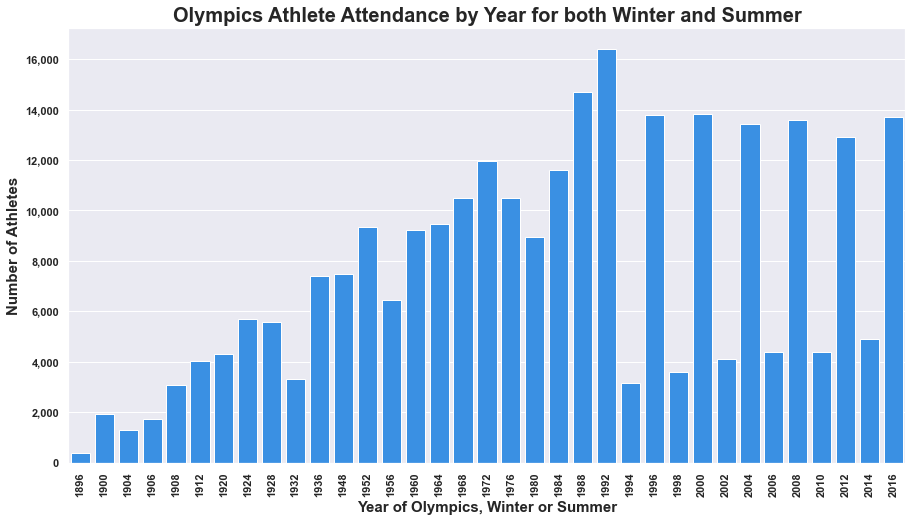

In [148]:
ax=sns.barplot(x='Year', y='Athletes', data=all_athletes_yearly, color='dodgerblue')
ax.set_title('Olympics Athlete Attendance by Year for both Winter and Summer', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics, Winter or Summer",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.2 Olympics Athlete Attendance by Year by Winter/Summer***

In [155]:
#Data preparation
all_athletes_year_season =olympics.groupby(['Year','Season'])[['ID']].count().reset_index()

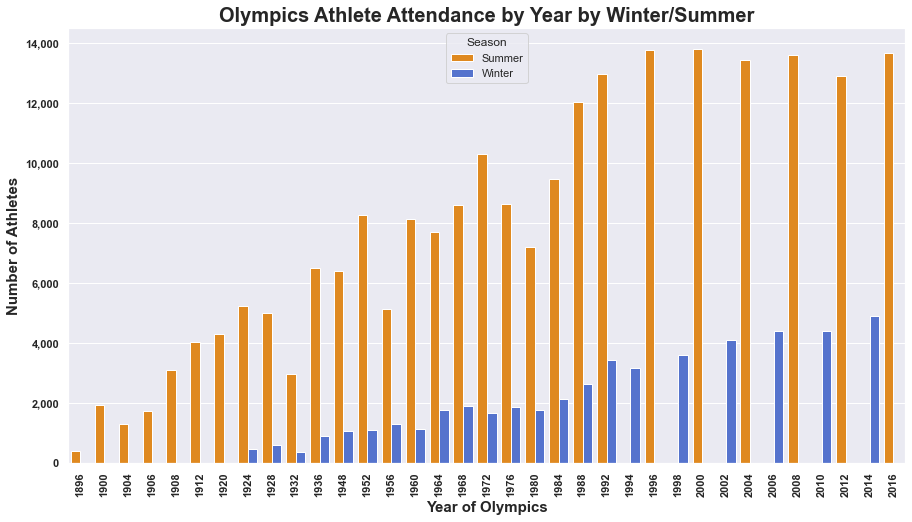

In [174]:
ax=sns.barplot(x='Year', y='ID', hue = 'Season', data=all_athletes_year_season, palette=['darkorange', 'royalblue'])
#ax=sns.countplot(x='Year', hue = 'Season', data=olympics, palette=['darkorange', 'royalblue'])
ax.set_title('Olympics Athlete Attendance by Year by Winter/Summer', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

***2.3 All Olympics Athlete Attendance by Year, Gender***

In [176]:
#Data preparation
all_athletes_year_sex = olympics.groupby(['Year','Sex'])[['ID']].count().reset_index()

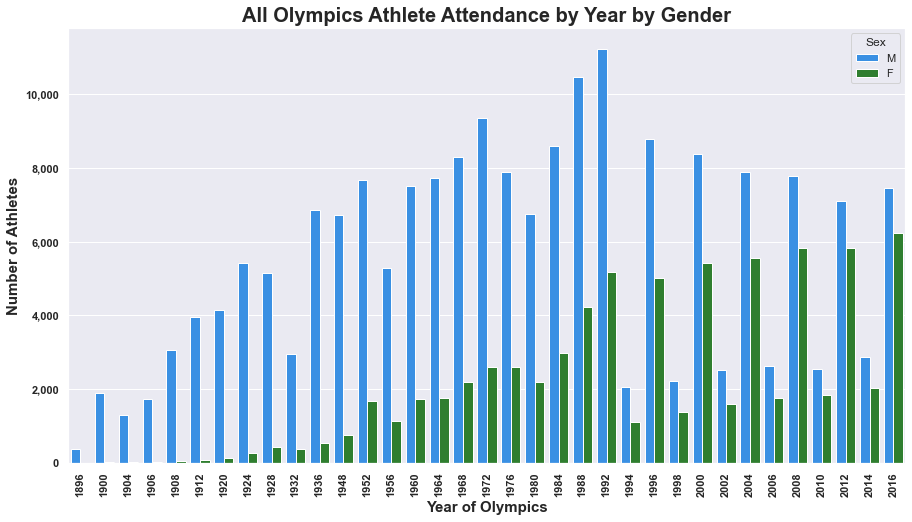

In [177]:
ax=sns.barplot(x='Year', y='ID', hue = 'Sex', data=all_athletes_year_sex, palette=['dodgerblue', 'forestgreen'])
ax.set_title('All Olympics Athlete Attendance by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.4 Summer Olympics Athlete Attendance by Year, Gender***

In [178]:
#Data preparation
all_athletes_summer_sex = summer.groupby(['Year','Sex'])[['ID']].count().reset_index()

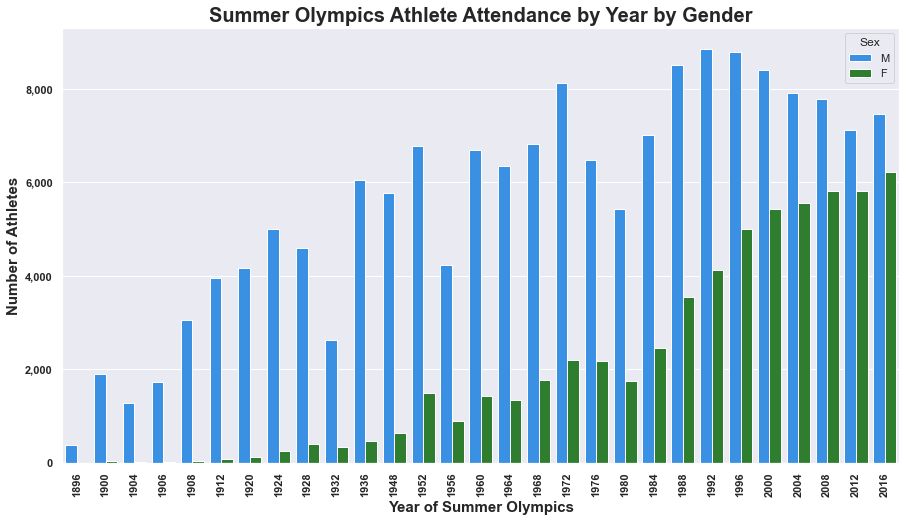

In [184]:
#ax=sns.barplot(x='Year', y='ID', hue = 'Sex', data=all_athletes_summer_sex, palette=['dodgerblue', 'forestgreen'])
ax=sns.countplot(x='Year', hue = 'Sex', data=summer, palette=['dodgerblue', 'forestgreen'])
ax.set_title('Summer Olympics Athlete Attendance by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Summer Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.5 Winter Olympics Athlete Attendance by Year, Gender***

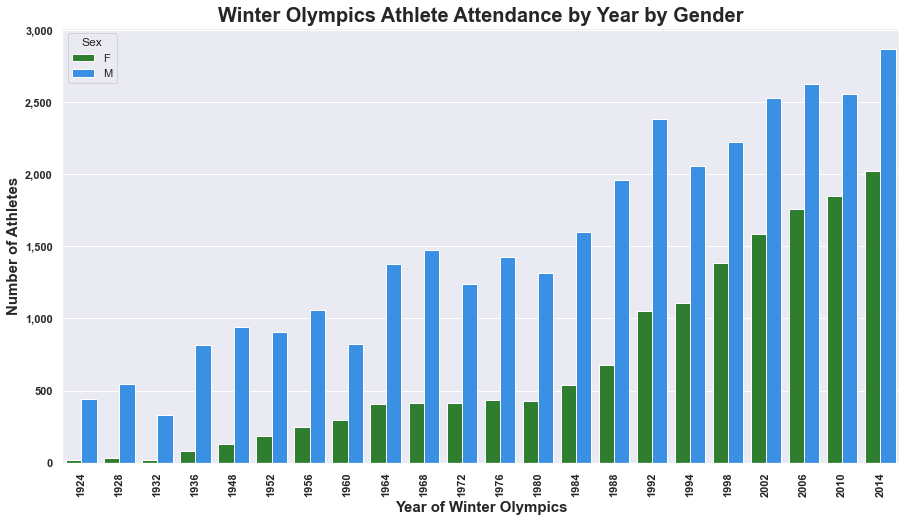

In [111]:
ax=sns.countplot(x='Year', hue = 'Sex', data=winter, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Winter Olympics Athlete Attendance by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Winter Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.6 All Summer Olympics Sports by Gender***

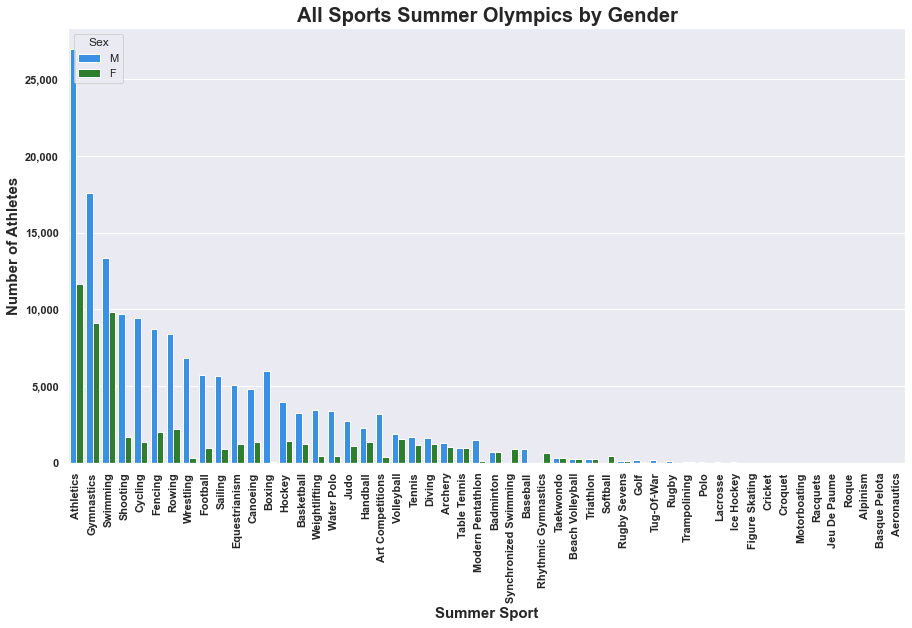

In [112]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=summer, palette=['dodgerblue', 'forestgreen'],order=summer['Sport'].value_counts().index)
ax.set_title('All Sports Summer Olympics by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Summer Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

In [113]:
sports = summer['Sport'].value_counts()

In [114]:
sports_3k=sports[sports > 3000]
sports_3k_less=sports[sports <= 3000]

***2.7 Major Sport Summer Olympics by Gender, with at least 3,000 Athletes all time***

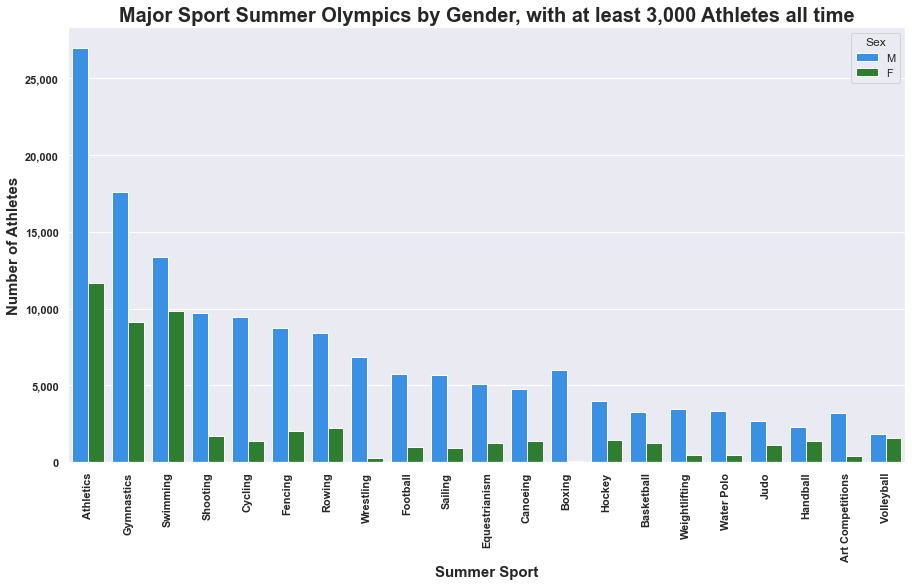

In [115]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=summer[summer['Sport'].isin(sports_3k.index)], palette=['dodgerblue', 'forestgreen'], order=sports_3k.index)
ax.set_title('Major Sport Summer Olympics by Gender, with at least 3,000 Athletes all time', fontsize = 20,weight='bold')
ax.set_xlabel("Summer Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.8 Minor Sport Summer Olympics by Gender, with less than 3,000 Athletes all time***

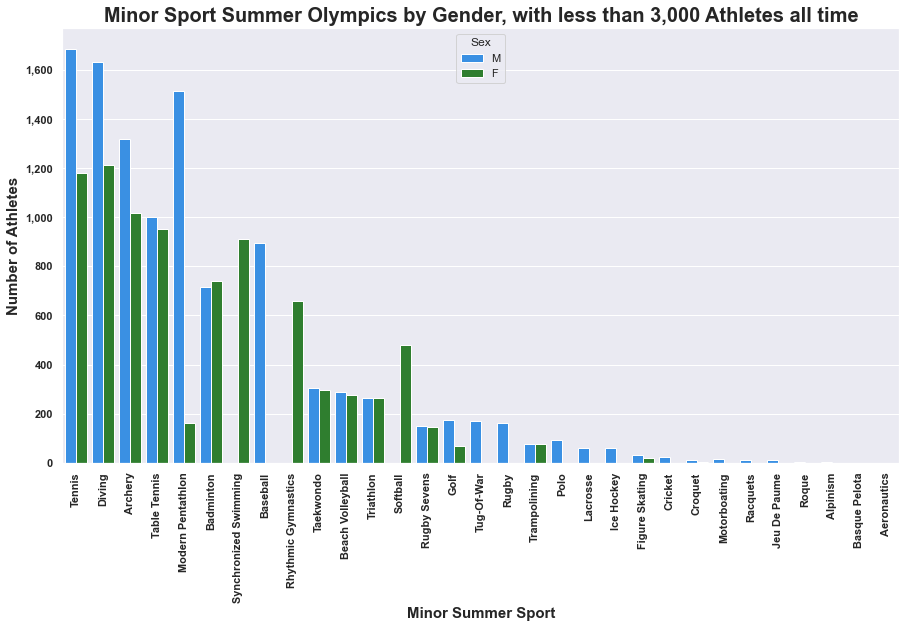

In [116]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=summer[summer['Sport'].isin(sports_3k_less.index)], palette=['dodgerblue', 'forestgreen'], order=sports_3k_less.index)
ax.set_title('Minor Sport Summer Olympics by Gender, with less than 3,000 Athletes all time', fontsize = 20,weight='bold')
ax.set_xlabel("Minor Summer Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.9 All Winter Olympics Sports by Gender***

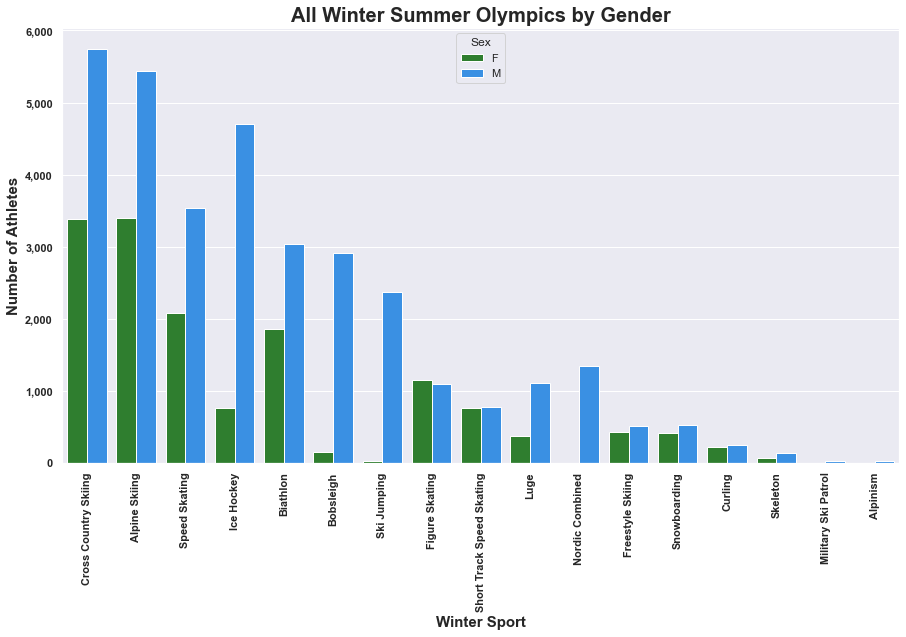

In [117]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=winter, palette=['forestgreen', 'dodgerblue'],order=winter['Sport'].value_counts().index)
ax.set_title('All Winter Summer Olympics by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Winter Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.9 No of Unique Sports over the years***

In [208]:
yearly_sports = pd.read_sql_query("select Year, Season, COUNT(DISTINCT(Sport)) AS NoOfSports from Olympics GROUP BY Year, Season;", conn)

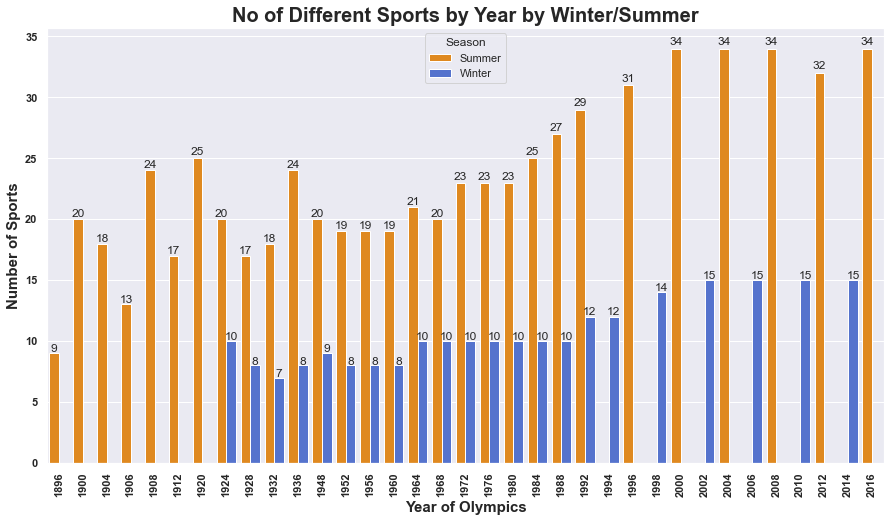

In [211]:
ax=sns.barplot(x='Year', y='NoOfSports', hue = 'Season', data=yearly_sports, palette=['darkorange', 'royalblue'])
#ax=sns.countplot(x='Year', hue = 'Season', data=olympics, palette=['darkorange', 'royalblue'])
ax.set_title('No of Different Sports by Year by Winter/Summer', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Sports',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
show_values(ax)

***2.9 No of Unique Countries participating over the years***

In [214]:
yearly_countries = pd.read_sql_query("select Year, Season, COUNT(DISTINCT(NOC)) AS NoOfCountries from Olympics GROUP BY Year, Season;", conn)

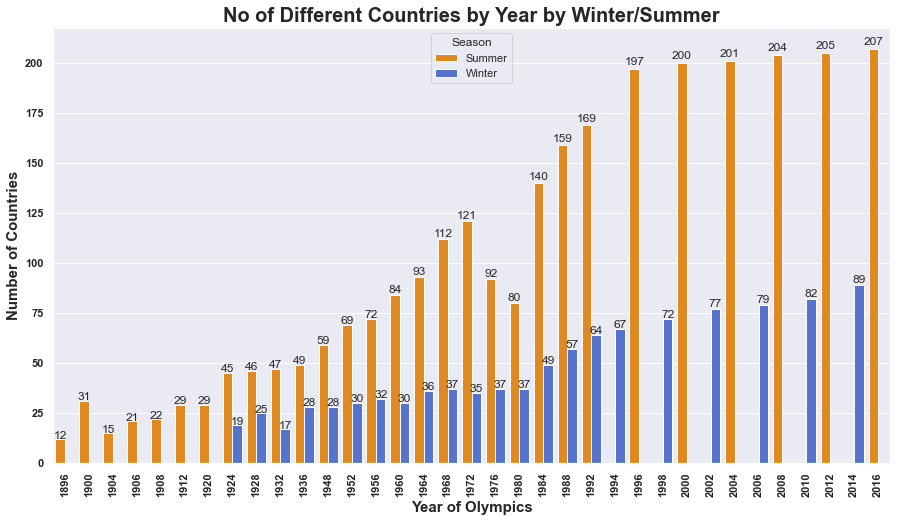

In [277]:
ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
#ax=sns.countplot(x='Year', hue = 'Season', data=olympics, palette=['darkorange', 'royalblue'])
ax.set_title('No of Different Countries by Year by Winter/Summer', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Countries',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
show_values(ax)

In [204]:
#yearly_sports = olympics.groupby(['Year', 'Season'])[['Sport']].nunique().reset_index()

## Individuals

***Completeness of Individual Data***

In [269]:
indv_complete = pd.read_sql_query("""
select Year, 'Age ' AS Variable,
    COUNT(*) AS Athletes, COUNT(Age) AS CompleteRecords
    from Olympics
GROUP BY Year
UNION
select Year, 'Weight ' AS Variable,
    COUNT(*) AS Athletes, COUNT(Weight) AS CompleteRecords
    from Olympics
GROUP BY Year
UNION
select Year, 'Height ' AS Variable,
        COUNT(*) AS Athletes, COUNT(Height) AS CompleteRecords
        from Olympics
    GROUP BY Year""", conn)
indv_complete['Completeness'] = 100 * indv_complete['CompleteRecords']/indv_complete['Athletes']
indv_complete

Year Variable  Athletes  CompleteRecords  Completeness
0    1896     Age        380              217     57.105263
1    1896  Height        380               46     12.105263
2    1896  Weight        380               49     12.894737
3    1900     Age       1936             1146     59.194215
4    1900  Height       1936              116      5.991736
..    ...      ...       ...              ...           ...
100  2014  Height       4891             4871     99.591086
101  2014  Weight       4891             4673     95.542834
102  2016     Age      13688            13688    100.000000
103  2016  Height      13688            13512     98.714202
104  2016  Weight      13688            13465     98.370836

[105 rows x 5 columns]

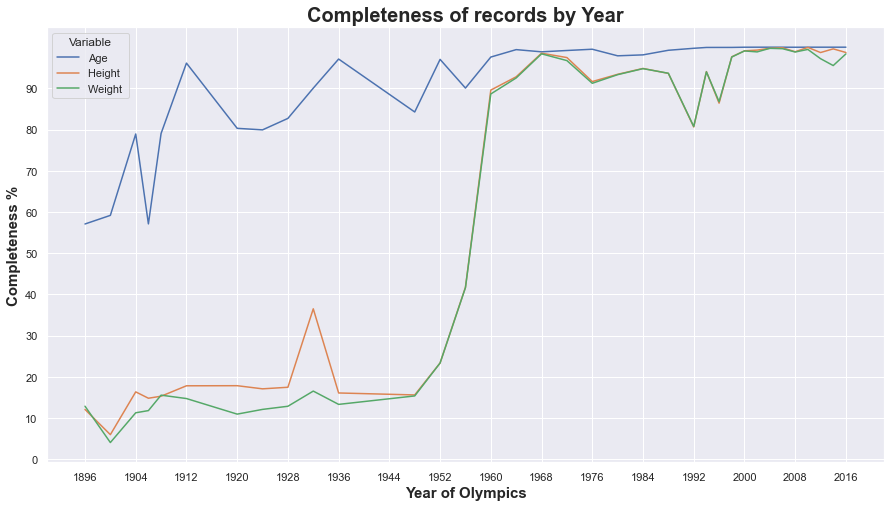

In [278]:
#ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
ax=sns.lineplot(x='Year', y='Completeness',hue = 'Variable', data=indv_complete)
ax.set_title('Completeness of records by Year', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Completeness %',fontsize = 15,weight='bold' );
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

plt.yticks(list(range(0,100,10)));
plt.xticks(list(range(1896,2020,8)));

#ticks_loc = ax.get_yticks().tolist();
#ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
#ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

***Age Over time***

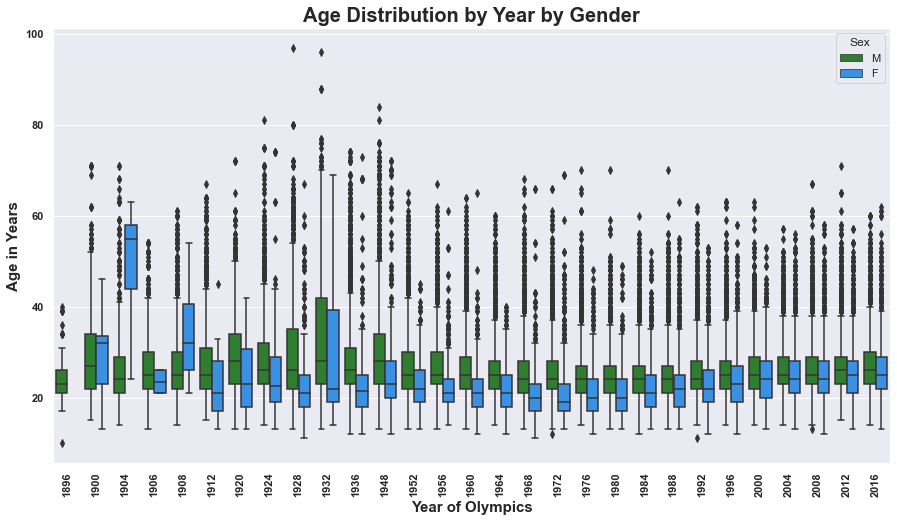

In [225]:
#ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
ax=sns.boxplot(x='Year', y='Age',hue = 'Sex', data=summer, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Age Distribution by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Age in Years',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

***Weight Over time***

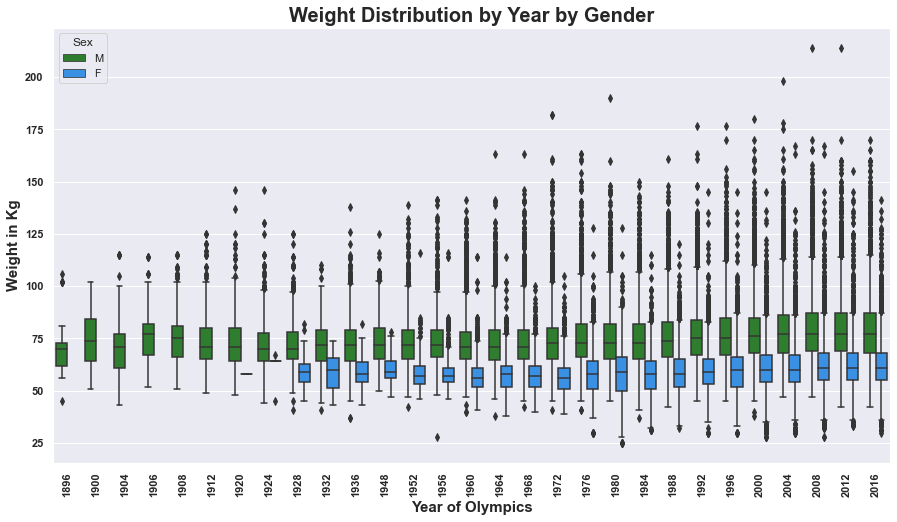

In [231]:
#ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
ax=sns.boxplot(x='Year', y='Weight',hue = 'Sex', data=summer, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Weight Distribution by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Weight in Kg',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

***Height Over time***

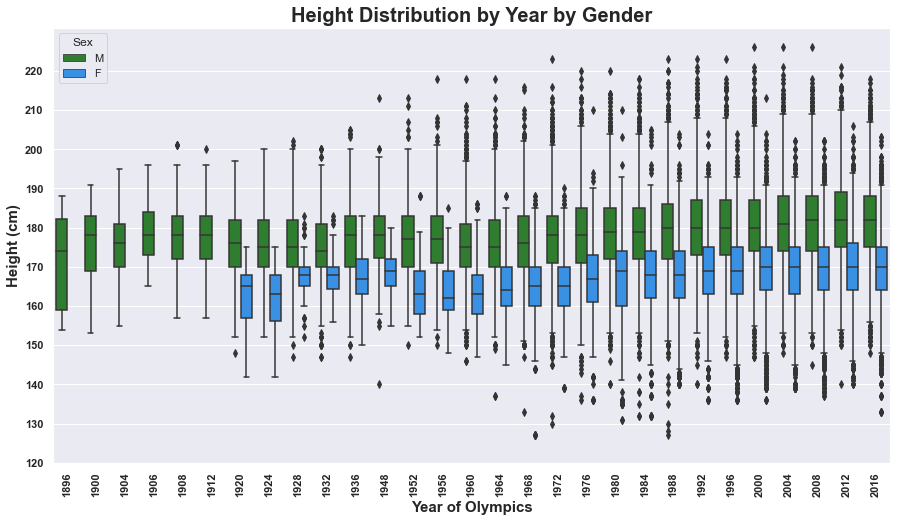

In [274]:
#ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
ax=sns.boxplot(x='Year', y='Height',hue = 'Sex', data=summer, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Height Distribution by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Height (cm)',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');
plt.yticks(list(range(120,230,10)))

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

***Scatter Plot of Height and Weight by Gender***

Text(0, 0.5, 'Mass (Kgs)')

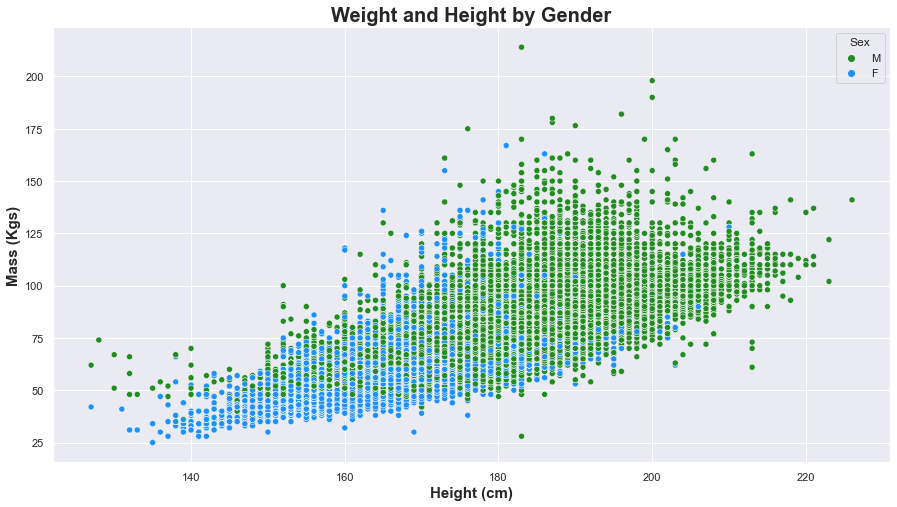

In [280]:
#ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
ax=sns.scatterplot(x='Height', y='Weight',hue = 'Sex', data=summer, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Weight and Height by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Height (cm)",fontsize = 15, weight='bold')
ax.set_ylabel('Mass (Kgs)',fontsize = 15,weight='bold' );
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

#ticks_loc = ax.get_yticks().tolist();
#ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
#ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

***Weight Over time***

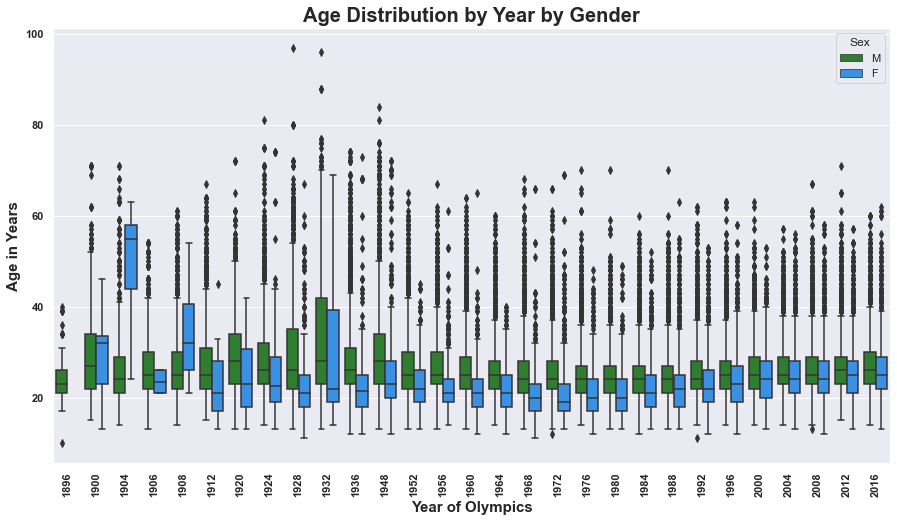

In [225]:
#ax=sns.barplot(x='Year', y='NoOfCountries', hue = 'Season', data=yearly_countries, palette=['darkorange', 'royalblue'])
ax=sns.boxplot(x='Year', y='Age',hue = 'Sex', data=summer, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Age Distribution by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Age in Years',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc], weight='bold');
#show_values(ax)

## Countries

## Sports Performance

## Hypothesis

In [118]:
(pd.crosstab(olympics['Year'], olympics['City'])>0).astype(int).sum()

City
Albertville               1
Amsterdam                 1
Antwerpen                 1
Athina                    3
Atlanta                   1
Barcelona                 1
Beijing                   1
Berlin                    1
Calgary                   1
Chamonix                  1
Cortina d'Ampezzo         1
Garmisch-Partenkirchen    1
Grenoble                  1
Helsinki                  1
Innsbruck                 2
Lake Placid               2
Lillehammer               1
London                    3
Los Angeles               2
Melbourne                 1
Mexico City               1
Montreal                  1
Moskva                    1
Munich                    1
Nagano                    1
Oslo                      1
Paris                     2
Rio de Janeiro            1
Roma                      1
Salt Lake City            1
Sankt Moritz              2
Sapporo                   1
Sarajevo                  1
Seoul                     1
Sochi                     1
Squaw Valley   

In [191]:
city_hosts = olympics.groupby(['City','Season','Year'])[['ID']].count()

In [119]:
olympics['Country'].value_counts()

USA            18853
Germany        15883
France         12758
UK             12256
Russia         11692
               ...  
Timor-Leste        9
Kosovo             8
Tuvalu             7
South Sudan        3
Unknown            2
Name: Country, Length: 209, dtype: int64

In [120]:
#df = pd.read_sql_query("select * from Olympics LIMIT 15;", conn)

df = %sql select * from Olympics LIMIT 15;

#print the dataframe
df

 * sqlite:///Olympics.db
Done.


[(1, 'A Dijiang', 'M', 24.0, 180.0, 80.0, 'China', 'CHN', '1992 Summer', 1992, 'Summer', 'Barcelona', 'Basketball', "Basketball Men's Basketball", None),
 (2, 'A Lamusi', 'M', 23.0, 170.0, 60.0, 'China', 'CHN', '2012 Summer', 2012, 'Summer', 'London', 'Judo', "Judo Men's Extra-Lightweight", None),
 (3, 'Gunnar Nielsen Aaby', 'M', 24.0, None, None, 'Denmark', 'DEN', '1920 Summer', 1920, 'Summer', 'Antwerpen', 'Football', "Football Men's Football", None),
 (4, 'Edgar Lindenau Aabye', 'M', 34.0, None, None, 'Denmark/Sweden', 'DEN', '1900 Summer', 1900, 'Summer', 'Paris', 'Tug-Of-War', "Tug-Of-War Men's Tug-Of-War", 'Gold'),
 (5, 'Christine Jacoba Aaftink', 'F', 21.0, 185.0, 82.0, 'Netherlands', 'NED', '1988 Winter', 1988, 'Winter', 'Calgary', 'Speed Skating', "Speed Skating Women's 500 metres", None),
 (5, 'Christine Jacoba Aaftink', 'F', 21.0, 185.0, 82.0, 'Netherlands', 'NED', '1988 Winter', 1988, 'Winter', 'Calgary', 'Speed Skating', "Speed Skating Women's 1,000 metres", None),
 (5, 'Christine Jacoba Aaftink', 'F', 25.0, 185.0, 82.0, 'Netherlands', 'NED', '1992 Winter', 1992, 'Winter', 'Albertville', 'Speed Skating', "Speed Skating Women's 500 metres", None),
 (5, 'Christine Jacoba Aaftink', 'F', 25.0, 185.0, 82.0, 'Netherlands', 'NED', '1992 Winter', 1992, 'Winter', 'Albertville', 'Speed Skating', "Speed Skating Women's 1,000 metres", None),
 (5, 'Christine Jacoba Aaftink', 'F', 27.0, 185.0, 82.0, 'Netherlands', 'NED', '1994 Winter', 1994, 'Winter', 'Lillehammer', 'Speed Skating', "Speed Skating Women's 500 metres", None),
 (5, 'Christine Jacoba Aaftink', 'F', 27.0, 185.0, 82.0, 'Netherlands', 'NED', '1994 Winter', 1994, 'Winter', 'Lillehammer', 'Speed Skating', "Speed Skating Women's 1,000 metres", None),
 (6, 'Per Knut Aaland', 'M', 31.0, 188.0, 75.0, 'United States', 'USA', '1992 Winter', 1992, 'Winter', 'Albertville', 'Cross Country Skiing', "Cross Country Skiing Men's 10 kilometres", None),
 (6, 'Per Knut Aaland', 'M', 31.0, 188.0, 75.0, 'United States', 'USA', '1992 Winter', 1992, 'Winter', 'Albertville', 'Cross Country Skiing', "Cross Country Skiing Men's 50 kilometres", None),
 (6, 'Per Knut Aaland', 'M', 31.0, 188.0, 75.0, 'United States', 'USA', '1992 Winter', 1992, 'Winter', 'Albertville', 'Cross Country Skiing', "Cross Country Skiing Men's 10/15 kilometres Pursuit", None),
 (6, 'Per Knut Aaland', 'M', 31.0, 188.0, 75.0, 'United States', 'USA', '1992 Winter', 1992, 'Winter', 'Albertville', 'Cross Country Skiing', "Cross Country Skiing Men's 4 x 10 kilometres Relay", None),
 (6, 'Per Knut Aaland', 'M', 33.0, 188.0, 75.0, 'United States', 'USA', '1994 Winter', 1994, 'Winter', 'Lillehammer', 'Cross Country Skiing', "Cross Country Skiing Men's 10 kilometres", None)]

### 1.3.6 Adding New Variables

***Will add EventScore, Gold ->10, Silver ->7, Bronze->5, or NA->1 for qualifying.<br>***
***Will add medal binary, Gold ->1, Silver ->1, Bronze->1, or NA-0 <br>***
***Rename region to Country***

In [121]:
#Gold 10 points
olympics.loc[olympics['Medal']=='Gold', 'EventScore'] = 10
#Silver 7 points
olympics.loc[olympics['Medal']=='Silver', 'EventScore'] = 7.5
#Bronze 4 points
olympics.loc[olympics['Medal']=='Bronze', 'EventScore'] = 5
#Qualification and attendance 1 points
olympics.loc[olympics['Medal'].isnull(), 'EventScore'] = 1
#olympics["region"]=np.where(olympics["region"].isnull(), olympics["notes"],olympics["region"])

In [122]:
olympics['Medal'].value_counts()

Gold      13372
Bronze    13295
Silver    13116
Name: Medal, dtype: int64

In [123]:
olympics['EventScore'].value_counts()

1.0     231333
10.0     13372
5.0      13295
7.5      13116
Name: EventScore, dtype: int64

In [124]:
olympics.columns

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'NOC', 'Country',
       'notes', 'EventScore'],
      dtype='object')

In [125]:
#olympics.rename(columns = {'region':'Country'}, inplace = True)

In [126]:
olympics.columns

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'NOC', 'Country',
       'notes', 'EventScore'],
      dtype='object')

In [127]:
# Close the connection to the SQLite Database
conn.close()
print("SQLite Database Connection Closed Sucessfully")

SQLite Database Connection Closed Sucessfully


In [128]:
print(style.GREEN + style.BOLD,"\n",datetime.datetime.now() - startTime, "Time running\n")

 
 0:00:28.977470 Time running

